In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
from utils import show_batch, AverageMeter, show_grid, calculate_metrics, show_cfs_matrix
from learner import FixMatch, BaseLine
from dataset import GIDataset, get_transform

In [6]:
_HYPER_KVASIR = 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images_deform'
_RESOURCE = '../resource/hyper_kvasir/full_labeled_anno.csv'

In [7]:
%pwd

'C:\\Users\\Admin\\working\\python\\mine\\endoscopic\\code'

In [8]:
df_full = pd.read_csv(_RESOURCE)
df_full.head()

,Organ,Classification,Finding,Image,Categories,is_valid
0,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/c7e...,0,False
1,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...,0,False
2,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
3,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
4,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/b98...,0,False


In [9]:
# df_full['Categories'].value_counts()

In [10]:
config = {}

config['data_path'] = _HYPER_KVASIR
config['size'] = 224
config['num_classes'] = 13
config['batch_size'] = 16
config['num_workers'] = 0
config['output_nodes'] = 1
config['epochs'] = 10
config['lr'] = 1e-3
config['mu'] = 7

config['lr'] = 1e-3
config['lr_step_size'] = 10
config['lr_gamma'] = 0.8

config['momentum'] = 0.9
config['weight_decay'] = 0.05
config['eval_step'] = 16
config['threshold'] = 0.95
config['T'] = 1.0
config['lambda_u'] = 0.9
config['freq_eval'] = 1
config['sch_name'] = 'step'
config['use_ema'] = True
config['ema_decay'] = 0.999

In [11]:
df_train = df_full[df_full['is_valid']==False]
## break down into labeled and unlabeled set
# df_labeled, df_unlabeled = train_test_split(df_train, test_size = 0.9, random_state = 0)
# df_labeled = df_labeled.reset_index();
# df_unlabeled = df_unlabeled.reset_index();

In [12]:
df_train

,Organ,Classification,Finding,Image,Categories,is_valid
0,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/c7e...,0,False
1,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...,0,False
2,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
3,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
4,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/b98...,0,False
...,...,...,...,...,...,...
7991,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/f38...,0,False
7992,lower-gi-tract,quality-of-mucosal-views,bbps-0-1,lower-gi-tract/quality-of-mucosal-views/bbps-0...,0,False
7993,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...,0,False
7994,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/dd4...,0,False


In [13]:
df_full[df_full['is_valid']==True]

,Organ,Classification,Finding,Image,Categories,is_valid
7996,lower-gi-tract,anatomical-landmarks,cecum,lower-gi-tract/anatomical-landmarks/cecum/72f8...,0,True
7997,upper-gi-tract,anatomical-landmarks,pylorus,upper-gi-tract/anatomical-landmarks/pylorus/2e...,0,True
7998,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...,0,True
7999,upper-gi-tract,anatomical-landmarks,pylorus,upper-gi-tract/anatomical-landmarks/pylorus/98...,0,True
8000,lower-gi-tract,quality-of-mucosal-views,bbps-0-1,lower-gi-tract/quality-of-mucosal-views/bbps-0...,0,True
...,...,...,...,...,...,...
10657,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/96...,5,True
10658,lower-gi-tract,pathological-findings,ulcerative-colitis-grade-3,lower-gi-tract/pathological-findings/ulcerativ...,2,True
10659,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/10a...,0,True
10660,upper-gi-tract,anatomical-landmarks,pylorus,upper-gi-tract/anatomical-landmarks/pylorus/8c...,0,True


In [14]:
# train_labeled_ds = GIDataset(df = df_labeled, config = config, transforms = get_transform(config, is_train=True))
# train_unlabeled_ds = GIDataset(df = df_unlabeled, config = config, transforms = get_transform(config, is_train=True, is_labeled=False))
train_ds = GIDataset(df = df_full[df_full['is_valid']==False], config = config, transforms = get_transform(config, is_train=True))
valid_ds = GIDataset(df = df_full[df_full['is_valid']==True] , config = config, transforms = get_transform(config))

In [15]:
# train_labeled_dl = DataLoader(train_labeled_ds, 
#                               sampler=RandomSampler(train_labeled_ds),
#                               batch_size = config['batch_size'], 
#                               num_workers = config['num_workers'])

# train_unlabeled_dl = DataLoader(train_unlabeled_ds, 
#                               sampler=RandomSampler(train_unlabeled_ds),
#                               batch_size = config['batch_size']*config['mu'], 
#                               num_workers = config['num_workers'])

train_dl = DataLoader(train_ds, 
                      sampler=RandomSampler(train_ds),
                      batch_size = config['batch_size'], 
                      num_workers = config['num_workers'])

valid_dl = DataLoader(valid_ds, 
                      sampler=SequentialSampler(valid_ds),
                      batch_size = config['batch_size'], 
                      num_workers = config['num_workers'])

torch.Size([16, 3, 224, 224])
tensor([10,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  7,  0,  0,  0])


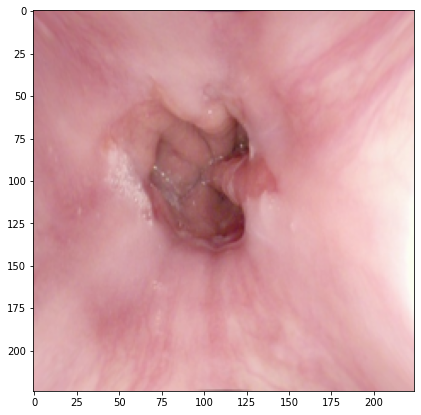

In [16]:
for x, y in train_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

torch.Size([16, 3, 224, 224])
tensor([ 0,  0,  0,  0,  0, 10,  0,  0,  4,  0,  0, 10,  0,  5, 12,  0])


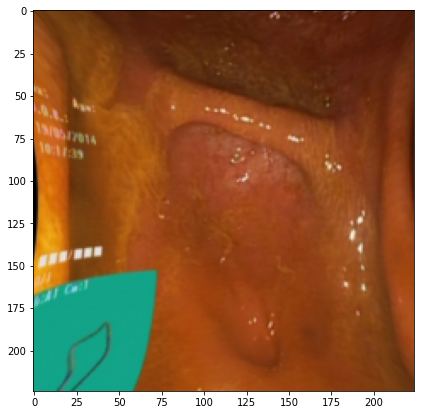

In [17]:
for x, y in valid_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

In [18]:
# x[0][100,:,:].shape

In [19]:
# for x, y in train_unlabeled_dl:
#     # print(x)
#     # print(y)
#     break
# show_grid([x[0][100,:,:]]+[x[1][100,:,:]])

In [20]:
model = nn.Sequential(timm.create_model('densenet161',pretrained=True,num_classes = config['num_classes']))

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [22]:
classifier = BaseLine(model = model,
                      opt_func="Adam", 
                      device = device)

classifier.get_config(config)
# classifier.get_dataloader((train_labeled_dl, train_unlabeled_dl), valid_dl)
classifier.get_dataloader(train_dl, valid_dl)

In [23]:
# classifier.fit()

In [24]:
# classifier.save_checkpoint('./')

In [25]:
classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\baseline_densenet161\\05_16_2022_10_07_15.pth', is_train=True)

In [26]:
list_outputs, list_targets = classifier.test_one()

100%|████████████████████████████████████████████████████████████| 167/167 [16:52<00:00,  6.06s/it]


In [27]:
# o = [np.argmax(item) for item in tqdm(list_outputs)]

In [28]:
metric = calculate_metrics(list_outputs, list_targets)

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
metric

{'micro/precision': 0.9062265566391597,
 'micro/recall': 0.9062265566391597,
 'micro/f1': 0.9062265566391597,
 'macro/precision': 0.3895256319001307,
 'macro/recall': 0.34960770873281216,
 'macro/f1': 0.3634513985156533}

In [30]:
print(classification_report(list_targets, list_outputs))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2021
           1       0.00      0.00      0.00        12
           2       0.87      0.51      0.65        39
           3       0.00      0.00      0.00         6
           4       0.46      0.33      0.39        57
           5       0.94      0.95      0.95       232
           6       0.00      0.00      0.00         4
           7       0.61      0.76      0.67       109
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         7
          10       0.49      0.36      0.42       100
          11       0.00      0.00      0.00         2
          12       0.74      0.64      0.69        70

    accuracy                           0.91      2666
   macro avg       0.39      0.35      0.36      2666
weighted avg       0.89      0.91      0.89      2666



C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


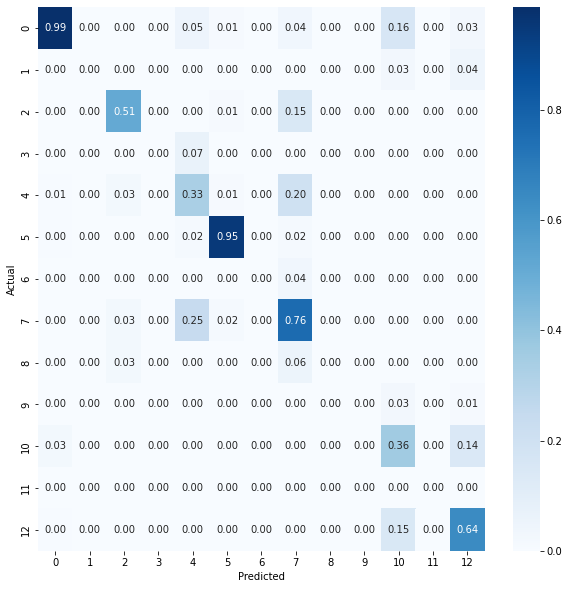

In [32]:
show_cfs_matrix(list_targets, list_outputs)

In [33]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [34]:
df_train[df_train['Categories']==12]

,Organ,Classification,Finding,Image,Categories,is_valid
12,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
23,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
52,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
123,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
170,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
...,...,...,...,...,...,...
7886,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
7899,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
7905,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False
7967,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,12,False


In [35]:
img_path = os.path.join(_HYPER_KVASIR, df_train['Image'].iloc[12])
image = np.array(Image.open(img_path))
image = cv2.resize(image, (224,224))

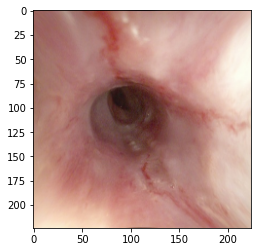

In [36]:
plt.imshow(image)

In [37]:
%pwd

'C:\\Users\\Admin\\working\\python\\mine\\endoscopic\\code'

In [38]:
cv2.imwrite('../resource/visualize/input.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

True

In [39]:
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
target_layers  = [classifier.model[0].features[-1]]
cam = GradCAM(model=classifier.model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

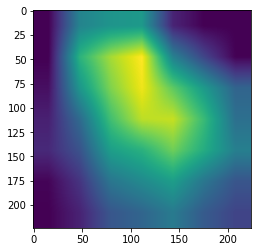

In [40]:
plt.imshow(grayscale_cam)

In [41]:
grayscale_cam = (grayscale_cam*255).astype(np.uint8)
# grayscale_cam

In [42]:
cv2.imwrite('../resource/visualize/graymap.jpg', grayscale_cam)

True

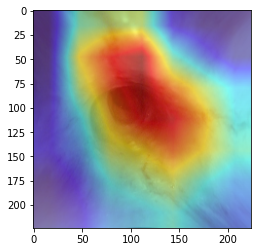

In [43]:
plt.imshow(visualization)

In [44]:
cv2.imwrite('../resource/visualize/saliency.jpg', cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))

True